<a href="https://colab.research.google.com/github/mayarmostaf/Hand-Gesture-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import mlflow
import mlflow.sklearn

#### Load Data

In [2]:
data = pd.read_csv('Data/data.csv')# with Tip Finger Scaling

In [3]:
# Load target_encoder
loaded_target_encoder = joblib.load('preprocessing_models/target_encoder.pkl')
data["target"]=loaded_target_encoder.transform(data["label"])

/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [4]:
data.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,x18,y18,x19,y19,x20,y20,x21,y21,label,target
0,-0.0,-0.0,0.116937,0.284998,0.070853,0.527849,-0.070324,0.658277,-0.204566,0.678748,...,-0.259614,0.432908,-0.513360,0.506663,-0.677775,0.547967,-0.803531,0.598925,call,0
1,-0.0,0.0,0.212194,0.209874,0.317203,0.503675,0.400779,0.717600,0.543429,0.854139,...,-0.303505,0.361148,-0.474125,0.515195,-0.595546,0.598857,-0.700357,0.687110,call,0
2,-0.0,0.0,0.163215,0.206895,0.291103,0.448452,0.405533,0.631460,0.549247,0.711291,...,-0.321010,0.385686,-0.479409,0.566446,-0.584172,0.668953,-0.660453,0.767535,call,0
3,-0.0,0.0,0.216994,0.209807,0.377769,0.451755,0.514657,0.631018,0.660991,0.751633,...,-0.308720,0.392306,-0.483455,0.548233,-0.592072,0.638965,-0.674876,0.724555,call,0
4,-0.0,0.0,0.162555,0.213698,0.304848,0.518366,0.437876,0.718476,0.598478,0.801207,...,-0.293942,0.370093,-0.464789,0.568068,-0.569755,0.682886,-0.646630,0.792322,call,0


##### Splitting

In [5]:
X=data.drop(columns=["label","target"])
Y=data["target"]

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["label","target"]), data["target"], test_size=0.2, random_state=42, stratify=data["target"])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(20540, 42)
(20540,)
(5135, 42)
(5135,)
target
15    0.064362
8     0.064216
3     0.063632
6     0.062025
13    0.061003
0     0.058666
10    0.058325
12    0.057741
11    0.056767
14    0.056719
9     0.056134
4     0.055940
17    0.053408
16    0.052288
1     0.050438
7     0.049172
5     0.042356
2     0.036806
Name: proportion, dtype: float64
target
15    0.064460
8     0.064265
3     0.063681
6     0.061928
13    0.061149
0     0.058617
10    0.058228
12    0.057644
11    0.056865
14    0.056670
9     0.056086
4     0.055891
17    0.053359
16    0.052386
1     0.050438
7     0.049270
5     0.042259
2     0.036806
Name: proportion, dtype: float64


### Model Selection

#### KNN

In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.sklearn
import joblib
import os

# Example input for signature inference
input_example = X_test[:3]  # Replace with your actual X_test slice

param_grid = {
    "n_neighbors": [3, 5, 7, 9, 11],
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}

best_accuracy = 0
best_params = None
best_model = None

os.makedirs("saved_models", exist_ok=True)

mlflow.set_experiment("KNN_Experiment")

# Run grid search manually with logging
for i, params in enumerate(ParameterGrid(param_grid)):
    with mlflow.start_run(run_name=f"KNN_Run_{i+1}"):
        # Train model
        model = KNeighborsClassifier(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        # Log params and metrics
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        # Save and log model as artifact
        model_filename = f"saved_models/knn_model_{i+1}.pkl"
        joblib.dump(model, model_filename)
        mlflow.log_artifact(model_filename)

        # Track the best model
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = params
            best_model = model

# Save best model to disk
joblib.dump(best_model, "best_knn_model.pkl")

print("Best Accuracy:", best_accuracy)
print("Best Params:", best_params)

# Log final best model with signature
with mlflow.start_run(run_name="Final Best Model"):
    signature = infer_signature(X_test, best_model.predict(X_test))
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", best_accuracy)
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="best_knn_model",
        input_example=input_example,
        signature=signature
    )
    mlflow.log_artifact("best_knn_model.pkl")


Best Accuracy: 0.9774099318403116
Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


#### XGBoost

In [19]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.xgboost
import joblib
import os

# Define hyperparameters grid (smaller for example speed)
param_grid = {
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [50, 100],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

best_accuracy = 0
best_params = None
best_model = None

os.makedirs("saved_models", exist_ok=True)
mlflow.set_experiment("XGBoost_Experiment")

input_example = X_test[:3]

for i, params in enumerate(ParameterGrid(param_grid)):
    with mlflow.start_run(run_name=f"XGB_Run_{i+1}"):
        model = XGBClassifier(
            use_label_encoder=False,
            eval_metric="mlogloss",
            random_state=42,
            **params
        )
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        model_filename = f"saved_models/xgb_model_{i+1}.pkl"
        joblib.dump(model, model_filename)
        mlflow.log_artifact(model_filename)

        if acc > best_accuracy:
            best_accuracy = acc
            best_params = params
            best_model = model
            # Save best model locally
            joblib.dump(best_model, "best_xgb_model.pkl")

print("Best Accuracy:", best_accuracy)
print("Best Params:", best_params)

with mlflow.start_run(run_name="Final Best XGB Model"):
    signature = infer_signature(X_test, best_model.predict(X_test))
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", best_accuracy)
    mlflow.xgboost.log_model(
        xgb_model=best_model,
        artifact_path="best_xgb_model",
        input_example=input_example,
        signature=signature
    )
    mlflow.log_artifact("best_xgb_model.pkl")

/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:31:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:31:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:31:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:32:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iterati

Best Accuracy: 0.9966893865628043
Best Params: {'colsample_bytree': 0.8, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1028: UserWarning: [10:52:36] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


#### SVC

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import ParameterGrid
from mlflow.models.signature import infer_signature
import mlflow
import mlflow.sklearn
import joblib
import os

# Example input for signature inference
input_example = X_test[:3]  # Replace with your actual X_test slice

param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [3, 4, 5],
    'gamma': ['scale', 'auto'],
    'coef0': [0, 0.1, 0.5],
    'shrinking': [True, False],
    'tol': [1e-3, 1e-4],
    'max_iter': [1000, 2000, -1]
}

best_accuracy = 0
best_params = None
best_model = None

os.makedirs("saved_models", exist_ok=True)

mlflow.set_experiment("SVC_Experiment")

for i, params in enumerate(ParameterGrid(param_grid)):
    with mlflow.start_run(run_name=f"SVC_Run_{i+1}"):
        # Train the model
        model = SVC(**params, random_state=42)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test, preds)
        f1 = f1_score(y_test, preds, average="macro")

        # Log parameters and metrics
        mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("f1_score", f1)

        # Save and log model artifact
        model_path = f"saved_models/svc_model_{i+1}.pkl"
        joblib.dump(model, model_path)
        mlflow.log_artifact(model_path)

        # Track the best model
        if acc > best_accuracy:
            best_accuracy = acc
            best_params = params
            best_model = model
            joblib.dump(best_model, "best_svc_model.pkl")

print("Best Accuracy:", best_accuracy)
print("Best Params:", best_params)

# Log the best model in a separate run with signature and input_example
with mlflow.start_run(run_name="Final Best SVC Model"):
    signature = infer_signature(X_test, best_model.predict(X_test))
    mlflow.log_params(best_params)
    mlflow.log_metric("accuracy", best_accuracy)
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="best_svc_model",
        input_example=input_example,
        signature=signature
    )
    mlflow.log_artifact("best_svc_model.pkl")

/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/ola/سطح المكتب

Best Accuracy: 0.9894839337877313
Best Params: {'C': 100, 'coef0': 0, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly', 'max_iter': 2000, 'shrinking': True, 'tol': 0.001}


##### Conclusion:
 SVC is The Best Model

### Model Evaluation

In [13]:
# Load the saved models
loaded_model = joblib.load('best_svc_model.pkl')
loaded_target_encoder = joblib.load('preprocessing_models/target_encoder.pkl')

/home/ola/سطح المكتب/MLOps_Project/venv/lib/python3.10/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


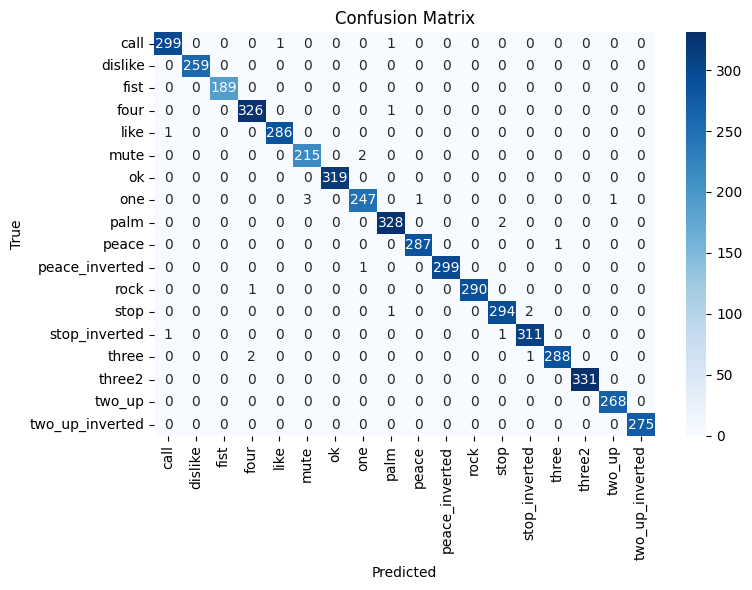


Classification Report:
                 precision    recall  f1-score   support

           call       0.99      0.99      0.99       301
        dislike       1.00      1.00      1.00       259
           fist       1.00      1.00      1.00       189
           four       0.99      1.00      0.99       327
           like       1.00      1.00      1.00       287
           mute       0.99      0.99      0.99       217
             ok       1.00      1.00      1.00       319
            one       0.99      0.98      0.98       252
           palm       0.99      0.99      0.99       330
          peace       1.00      1.00      1.00       288
 peace_inverted       1.00      1.00      1.00       300
           rock       1.00      1.00      1.00       291
           stop       0.99      0.99      0.99       297
  stop_inverted       0.99      0.99      0.99       313
          three       1.00      0.99      0.99       291
         three2       1.00      1.00      1.00       331
      

In [16]:
y_pred = loaded_model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=loaded_target_encoder.classes_,
            yticklabels=loaded_target_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=loaded_target_encoder.classes_))

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
